# JupyLSQEGen

Notebook Licence: [https://creativecommons.org/licenses/by/4.0/](https://creativecommons.org/licenses/by/4.0/)

Moving Parts:
* [Differential Cross-section for the Hard Scatter](#Differential-Cross-Section-for-the-CCQE-Hard-Scatter)
* [Kinematics Calculation](#Observable-Kinematics)
* [Monte Carlo Sampling](#Aside:-Monte-Carlo-Sampling)
* The Free Nucleon Event Generator
* Putting the Nucleon in Nucleus
* Energy Distributions


## Differential Cross Section for the CCQE Hard Scatter

We follow Llewellyn Smith model for a CCQE hard scatter: https://www.sciencedirect.com/science/article/pii/0370157372900105

Starting on page 300, $\S$ 3.3 Quasi-Elastic Neutrino Scattering ($\Delta Y = 0$) 

In [1]:
from math import *
import numpy as np

In [2]:
# Constants
## Units
fm = 5.068 # GeV^-1
cm2 = fm * fm * 1E26 # GeV^-2

## Physical Constants
GF = 1.1663787e-5  # Fermi coupling constant in GeV^-2
cos_theta_C = 0.97425  # Cosine of the Cabibbo angle
eta = 3.71

## Particle Masses
m_p = 0.938272  # Proton mass in GeV/c^2
m_n = 0.939565  # Neutron mass in GeV/c^2
m_mu = 0.105658  # Muon mass in GeV/c^2
m_e = 0.000511  # electron mass in GeV/c^2
m_pi = 0.1396  # pion mass in GeV/c^2

## Model Parameters
M_A_GeV = 1.34
M_V_GeV = 0.71
g_A = -1.23

### Nucleon Form Factors

#### Some Useful Pre-calculations

Some terms appear in the following model implementation more than once, as a 
result it is worth pre-calculating them and passing them around in a blob 
rather than recalculating each time and having many function arguments to 
keep track of.

In [3]:
class LSQEPreCalc(object):
    def __init__(self, Q2_GeV2, nupid):
        
        if abs(nupid) == 12:
            self.nuflv = 1
        elif abs(nupid) == 14:
            self.nuflv = 2
        else:
            raise RuntimeError("invalid nupid: %s passed to LSQEPreCalc" % nupid)
            
        self.nuornub = 1 if nupid > 0 else -1
        
        self.MNuc = m_n if self.nuornub == 1 else m_p
        self.mlep = m_e if self.nuflv == 1 else m_mu
        
        self.MNuc2 = self.MNuc * self.MNuc
        self.mlep2 = self.mlep*self.mlep
        
        self.m2_M2 = self.mlep2/self.MNuc2
    
        self.q2 = -Q2_GeV2
        self.q2_M2 = self.q2/self.MNuc2

In [4]:
#use like

Q2 = 1.0 # in GeV2
nupid = 14 # muon neutrino
lspc = LSQEPreCalc(1.0, 14)

#### EM/Vector

In [5]:
# p301 eqn 3.17 (left)
def GV_E(lspc):
    return 1.0 / pow(1.0 - lspc.q2/M_V_GeV,2)

# p301 eqn 3.17 (right)
def GV_M(lspc):
    return (1.0 + eta) / pow(1.0 - lspc.q2/M_V_GeV,2)

# p301 eqn 3.16 (top)
def F1_V_Sachs(lspc):
    return (GV_E(lspc) - 0.25 * lspc.q2_M2*GV_M(lspc))/(1.0 - 0.25 * lspc.q2_M2)

# p301 eqn 3.16 (bottom)
def etaF2_V_Sachs(lspc):
    return (GV_M(lspc) - GV_E(lspc))/(1.0 - 0.25 * lspc.q2_M2)

#### Axial

In [6]:
# p303 eqn 3.24
def dipole_FA(q2_GeV2, M_A_GeV):
    return g_A / pow((1 - (q2_GeV2/(M_A_GeV*M_A_GeV))),2)

#### Form Factor Blob

The form factors also appear multiple times in the cross section calculation 
and so it is worth providing a blob with them pre-calculated

In [7]:
class LSQEFFBlob(LSQEPreCalc):
    def __init__(self, Q2_GeV2, nupid):

        super().__init__(Q2_GeV2, nupid) # call the LSQEPreCalc constructor
        
        self.F1_V = F1_V_Sachs(self)
        self.F1_V2 = self.F1_V * self.F1_V
        self.etaF2_V = etaF2_V_Sachs(self)
        self.etaF2_V2 = self.etaF2_V * self.etaF2_V
        self.F3_V = 0
        self.F3_V2 = self.F3_V * self.F3_V

        self.F_A = dipole_FA(self.q2, M_A_GeV)
        self.F_A2 = self.F_A * self.F_A
        self.F3_A = 0
        self.F3_A2 = self.F3_A * self.F3_A

        # p305, unnumbered
        self.F_P = (2 * self.MNuc2 * self.F_A) / (m_pi*m_pi - self.q2)
        self.F_P2 = self.F_P*self.F_P

In [8]:
#use like

Q2 = 1.0 # in GeV2
nupid = 14 # muon neutrino
lsff = LSQEFFBlob(1.0, 14)

### The Differential Cross Section: $d\sigma/dQ^2$

In [9]:
#A, B, and C are all implemented from p302 eqn 3.22

def A(lsff):
    t1 = (4 - lsff.q2_M2)*lsff.F_A2
    t2 = (4 + lsff.q2_M2)*lsff.F1_V2
    t3 = lsff.q2_M2 * lsff.etaF2_V2*(1 + 0.25*lsff.q2_M2)
    t4 = 4*lsff.q2_M2*lsff.F1_V*lsff.etaF2_V
    t5 = lsff.q2_M2 * (4 - lsff.q2_M2) * lsff.F3_A2
    t6 = lsff.m2_M2 * ( pow(lsff.F1_V + lsff.etaF2_V,2) 
                  + pow(lsff.F_A + 2*lsff.F_P,2) 
                  + (lsff.q2_M2 - 4)*(lsff.F3_V2 + lsff.F_P2) )

    return (0.25*(lsff.mlep2 - lsff.q2)/lsff.MNuc2)*(t1 - t2 - t3 - t4 + t5 - t6)
    
def B(lsff):
    t1 = -lsff.q2_M2 * lsff.F_A * (lsff.F1_V + lsff.etaF2_V)
    t2 = lsff.m2_M2 * ( (lsff.F1_V + 0.25*lsff.q2_M2*lsff.etaF2_V)*lsff.F3_V 
                    - (lsff.F_A + 0.5*lsff.F_P*lsff.q2_M2) * lsff.F3_A )
    return t1 - t2

def C(lsff):
    t1 = lsff.F_A2
    t2 = lsff.F1_V2
    t3 = lsff.q2_M2 * 0.25 * lsff.etaF2_V2
    t4 = lsff.q2_M2 * lsff.F3_A2
    return 0.25 * ( t1 + t2 - t3 - t4 )

In [10]:
#p301 eqn 3.18
def LSQEDSigmaDQ2(E_nu_GeV, Q2_GeV2, nupid):
    if E_nu_GeV == 0:
        return 0
    
    lsff = LSQEFFBlob(Q2_GeV2, nupid)

    smu = 4 * lsff.MNuc2 * E_nu_GeV + lsff.q2 - lsff.mlep2
    
    return  (lsff.MNuc2 * GF * GF * pow(cos_theta_C,2))/(8*pi*E_nu_GeV*E_nu_GeV) \
            * ( A(lsff) 
                + -1 * lsff.nuornub * B(lsff) *smu / lsff.MNuc2 
                + C(lsff) * smu * smu / (lsff.MNuc2 * lsff.MNuc2)
              )

#### Plotting $d\sigma/dQ^2$

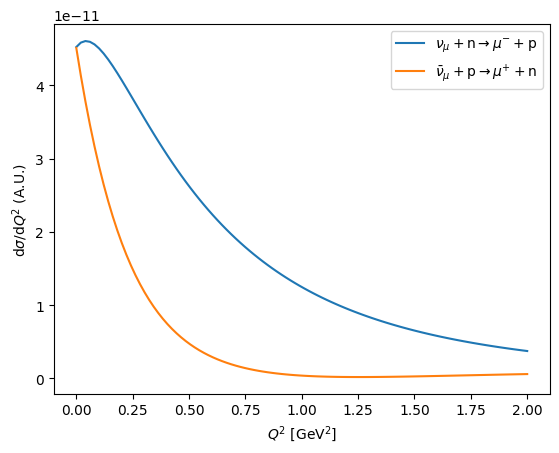

In [11]:
import matplotlib.pyplot as plt

def plotdx(E_nu_GeV, nupid):
    M_GeV = m_p
    m_GeV = m_mu

    Q2_GeV = np.linspace(0, 2,100) 

    dx = np.array([LSQEDSigmaDQ2(E_nu_GeV, Q2, abs(nupid)) for Q2 in Q2_GeV])
    dxb = np.array([LSQEDSigmaDQ2(E_nu_GeV, Q2, -abs(nupid)) for Q2 in Q2_GeV])
    
    plt.plot(Q2_GeV, dx, label=r"$\nu_{\mu} + \text{n} \rightarrow \mu^{-} + \text{p}$")
    plt.plot(Q2_GeV, dxb, label=r"$\bar{\nu}_{\mu} + \text{p} \rightarrow \mu^{+} + \text{n}$")
    plt.ylabel(r"d$\sigma$/d$Q^{2}$ (A.U.)")
    plt.xlabel(r"$Q^{2}$ [GeV$^{2}$]")
    plt.legend()
    plt.show()

enu = 1.0 # in GeV2
nupid = 14 # muon neutrino
plotdx(enu,nupid)

## Observable Kinematics

So now we can calculate $d\sigma/dQ^2$ at fixed $E_{\nu}$ and $Q^2$, but $Q^2$
is not observable. Lets see if we can calculate the observables.

Consider the interaction:

<div>
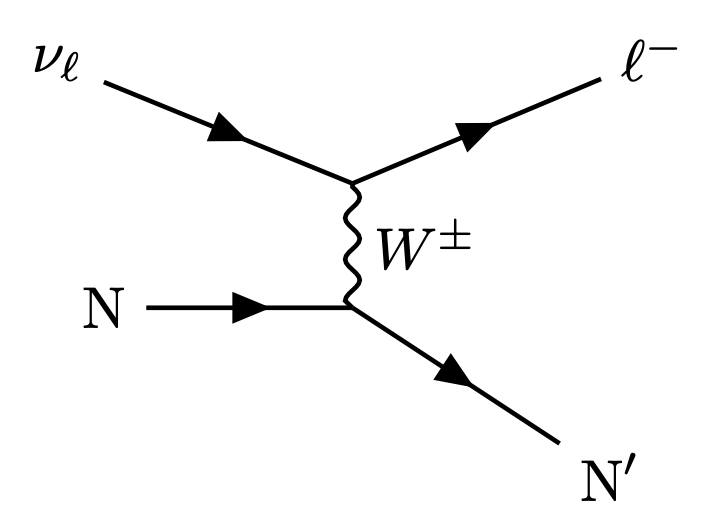
</div>

Choose coordinates such that: <br> 
$\vec{p}_\nu = \vec{p}_{\nu,z} = E_\nu$ <br>
$\vec{p}_N = 0$ <br>
$\vec{p}_{\ell,y} = \vec{p}_{{N^\prime},y} = 0$ <br>
In general, this choice may require a boost into the target nucleon rest frame 
and rotation, but should always be possible. The problem becomes 2D and we are 
left with 4 unknowns: $p_\ell$, $\cos{\theta_\ell}$, $p_{N^\prime}$, 
$\cos{\theta_{N^\prime}}$. These can be uniquely determined with energy 
conservation, momentum conservation along two axes, and the $Q^2$ that we take
as input.

**Energy conservation**: $E_\nu + E_N = E_\ell + E_{N^\prime}$ <br/>
Initial nucleon $N$ at rest: $E_N = M_N$, $\vec{p}_N = 0$ <br>
[1] $E_\nu + M_N = E_\ell + E_{N^\prime}$ <br/>

**Linear momentum along $\hat{z}$**: <br>
[2] $E_\nu = p_\mu \cos{\theta_\ell} + p_{N^\prime} \cos{\theta_{N^\prime}}$ <br>

**Linear momentum along $\hat{x}$**: <br>
[3] $p_\mu \sin{\theta_\ell} = p_{N^\prime} \sin{\theta_{N^\prime}}$ <br>

From [2]$^2+$[3]$^2$: $(E_\nu - p_\ell\cos{\theta_\ell})^2 + p_\ell\sin{\theta_\ell}^2 = p_{N^\prime}^2(\cos{\theta_{N^\prime}}^2 + \sin{\theta_{N^\prime}}^2)$ <br>
$\rightarrow E_\nu^2 - 2E_\nu p_\ell\cos{\theta_\ell} + p_\ell^2(\cos{\theta_\ell}^2 + \sin{\theta_\ell}) = p_{N^\prime}^2$ <br>
[4] $\cos{\theta_\ell} = (E_\nu^2 + p_\ell^2 - p_{N^\prime}^2)/(2E_\nu p_\ell)$ <br><br>

$Q^2 = -q^2 = q_3^2 - q_0^2$
We know $\vec{p}_N = 0 \rightarrow \vec{p}_{N^\prime} = \vec{q}_3$ and so: <br>
[5] $Q^2 = p_{N^\prime}^2 - q_0^2$

From [1]: $E_{N^\prime} = E_\nu - E_\ell + M_N = q_0 + M_N$ <br/>
[6] $q_0 = E_{N^\prime} - M_N$ <br>
Squaring [6] and substituting $E_{N^\prime}^2 = p_{N^\prime}^2 + M_{N^\prime}^2$ <br>
[7] $q_0^2 + M_N^2 + 2M_Nq_0 = p_{N^\prime}^2 + M_{N^\prime}^2$ <br>
Including [5] and rearranging: <br>
[8] $q_0 = (Q^2 - (M_N^2 - M_{N^\prime}^2))/2M_N$

So now we can uniquely find $q_0$ from a chosen $Q^2$. Often at this stage, 
the $(M_N^2 - M_{N^\prime}^2)/2M_N$ term is neglected as neglible, but for
reasons that will become clearer later, we retain it. We can calculate the
final state lepton energy from the definition of $q_0 = E_\nu - E_\ell$,
which lets us calculate $p_\ell$. 

Using [5]: $p_{N^\prime} = \sqrt{Q^2 + q_0^2}$ <br>

We can then use [4] to find $\cos{\theta_\ell}$ and [2] to find 
$\cos{\theta_{N^\prime}}$, thus fully specifying the kinematics of the 
interaction.

In [12]:
class KinematicsBlob(object):
    def CalcKinematics(self, E_nu_GeV, Q2_GeV2, nupid):
        MN = m_n if nupid > 0 else m_p
        MNpr = m_p if nupid > 0 else m_n
    
        if abs(nupid) == 12:
            mlep = m_e
        elif abs(nupid) == 14:
            mlep = m_mu
        else:
            raise RuntimeError("invalid nupid: %s passed to KinematicsBlob" % nupid)

        enu = E_nu_GeV
        Q2 = Q2_GeV2

        # From [8] above
        q0 = (Q2 - (pow(MN,2) - pow(MNpr,2)))/(2*MN)

        elep = enu - q0

        # If elep is less than the rest mass, 
        # or if the four-momentum transfer is ,
        # less than the change in nucleon mass,
        # the reaction is energetically disallowed
        if (q0 < 0) or (elep < mlep):
            return
        
        plep = sqrt(elep*elep - mlep*mlep)
        pnuc = sqrt(Q2 + pow(q0,2))

        # From [4] above
        lepct = (pow(enu,2) + pow(plep,2) - pow(pnuc,2))/(2*enu*plep)
        # From [2] above
        nucct = (enu - plep * lepct)/pnuc
        
        self.Q2 = Q2
        self.q0 = q0
        self.elep = elep
        self.plep = plep
        self.pnuc = pnuc
        self.lepct = lepct
        self.nucct = nucct
        
    def __init__(self, E_nu_GeV, Q2_GeV2, nupid):
        
        self.Q2 = 0
        self.q0 = 0
        self.elep = 0
        self.plep = 0
        self.pnuc = 0
        self.lepct = 0
        self.nucct = 0

        self.CalcKinematics(E_nu_GeV, Q2_GeV2, nupid)

#### Plotting the Kinematics

lets see how the observable kinematics vary as a function of $Q^2$:

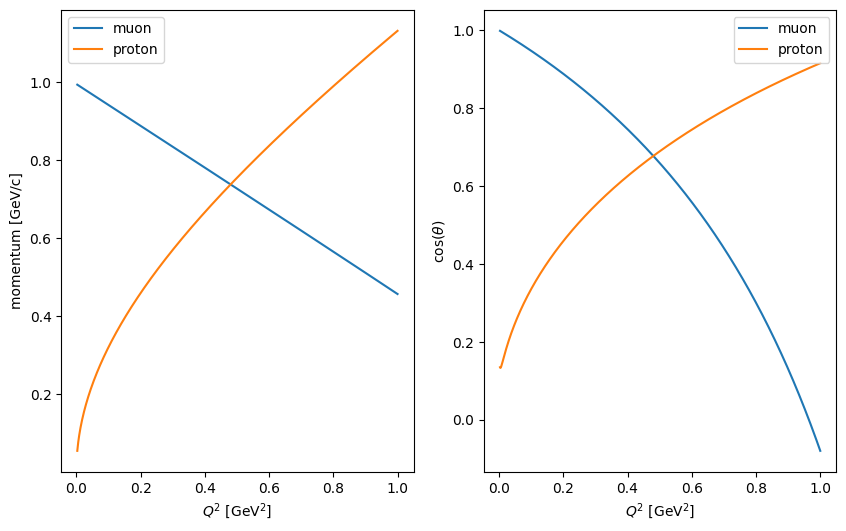

In [13]:
def plotkins(enu, Q2max):
    kins = []
    for Q2 in np.linspace(0,Q2max,1000):
        kb = KinematicsBlob(enu, Q2, 14)
        if kb.plep: #check whether it was energetically allowed
            kins.append(kb)
    
    Q2s = [x.Q2 for x in kins]
    pleps = [x.plep for x in kins]
    pnucs = [x.pnuc for x in kins]
    lepcts = [x.lepct for x in kins]
    nuccts = [x.nucct for x in kins]
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6))
    
    ax1.plot(Q2s,pleps,label="muon")
    ax1.plot(Q2s,pnucs,label="proton")
    ax1.set_ylabel("momentum [GeV/c]")
    ax1.set_xlabel(r"$Q^2$ [GeV$^2$]")
    ax1.legend()
    
    ax2.plot(Q2s,lepcts,label="muon")
    ax2.plot(Q2s,nuccts,label="proton")
    ax2.set_ylabel(r"$\cos(\theta)$")
    ax2.set_xlabel(r"$Q^2$ [GeV$^2$]")
    ax2.legend()
    
    fig.show()

enu = 1
plotkins(enu,enu)

Can $Q^2$ be larger than $E_\nu$?

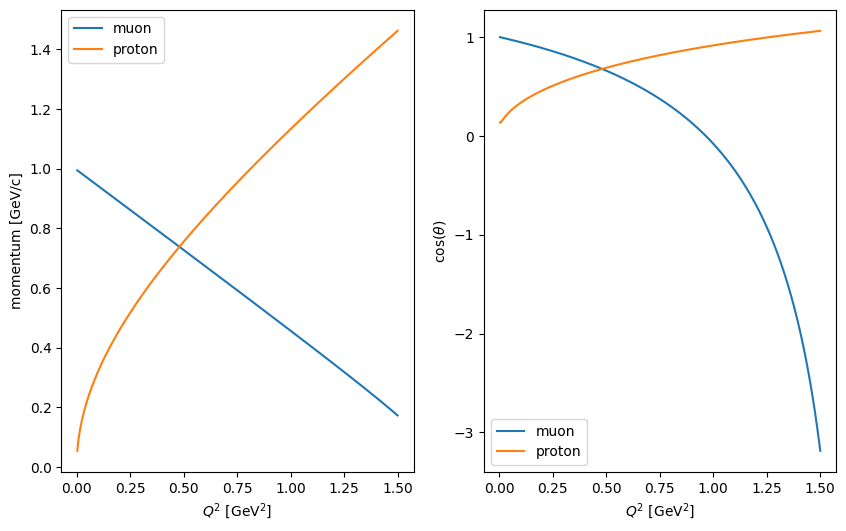

In [14]:
enu = 1
plotkins(enu,1.5*enu)

At some $Q^2 > Q^2_\text{max}$, momentum cannot be conserved as [4] suggests
$\cos{\theta_\ell} < -1$. We can extend our previous `KinematicsBlob` to report
failure if the kinematics are unphysical for a given $E_\nu$ and $Q^{2}$.

In [15]:
class PhysicalKinematicsBlob(KinematicsBlob):
    def __init__(self, E_nu_GeV, Q2_GeV2, nupid):
        super().__init__(E_nu_GeV, Q2_GeV2, nupid) # call the KinematicsBlob constructor
        if (self.elep == 0) or (abs(self.lepct) > 1):
            self.physical = False
        else:
            self.physical = True

enu = 1
Q2 = 1
pkb = PhysicalKinematicsBlob(enu,Q2,14)
print("Is Enu = 1, Q2 = 1 for numus kinematically allowed? %s" % pkb.physical)

enu = 1
Q2 = 1.28
pkb = PhysicalKinematicsBlob(enu,Q2,14)
print("Is Enu = 1, Q2 = 1.28 for numus kinematically allowed? %s" % pkb.physical)

enu = 1
Q2 = 1.28
pkb = PhysicalKinematicsBlob(enu,Q2,12)
print("Is Enu = 1, Q2 = 1.28 for nues kinematically allowed? %s" % pkb.physical)

enu = 1000
Q2 = 2*enu
pkb = PhysicalKinematicsBlob(enu,Q2,12)
print("Is Enu = 1000, Q2 = 2000 for nues kinematically allowed? %s" % pkb.physical)

Is Enu = 1, Q2 = 1 for numus kinematically allowed? True
Is Enu = 1, Q2 = 1.28 for numus kinematically allowed? False
Is Enu = 1, Q2 = 1.28 for nues kinematically allowed? True
Is Enu = 1000, Q2 = 2000 for nues kinematically allowed? False


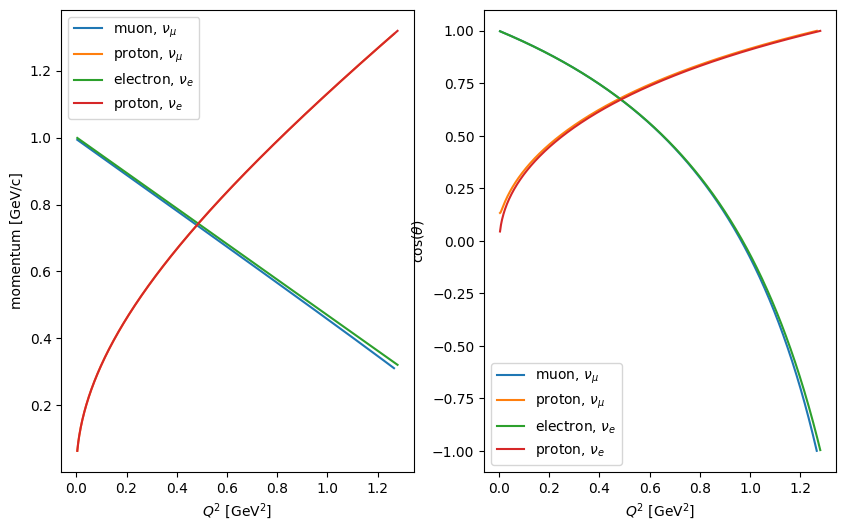

In [16]:
def plotphyskins(enu, Q2max):
    kinsnumu = []
    kinsnue = []
    for Q2 in np.linspace(0,Q2max,1000):
        kbnumu = PhysicalKinematicsBlob(enu, Q2, 14)
        if kbnumu.physical:
            kinsnumu.append(kbnumu)
            
        kbnue = PhysicalKinematicsBlob(enu, Q2, 12)
        if kbnue.physical:
            kinsnue.append(kbnue)
    
    Q2snumu = [x.Q2 for x in kinsnumu]
    plepsnumu = [x.plep for x in kinsnumu]
    pnucsnumu = [x.pnuc for x in kinsnumu]
    lepctsnumu = [x.lepct for x in kinsnumu]
    nucctsnumu = [x.nucct for x in kinsnumu]

    Q2snue = [x.Q2 for x in kinsnue]
    plepsnue = [x.plep for x in kinsnue]
    pnucsnue = [x.pnuc for x in kinsnue]
    lepctsnue = [x.lepct for x in kinsnue]
    nucctsnue = [x.nucct for x in kinsnue]
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6))
    
    ax1.plot(Q2snumu,plepsnumu,label=r"muon, $\nu_\mu$")
    ax1.plot(Q2snumu,pnucsnumu,label=r"proton, $\nu_\mu$")
    ax1.plot(Q2snue,plepsnue,label=r"electron, $\nu_e$")
    ax1.plot(Q2snue,pnucsnue,label=r"proton, $\nu_e$")
    ax1.set_ylabel("momentum [GeV/c]")
    ax1.set_xlabel(r"$Q^2$ [GeV$^2$]")
    ax1.legend()
    
    ax2.plot(Q2snumu,lepctsnumu,label=r"muon, $\nu_\mu$")
    ax2.plot(Q2snumu,nucctsnumu,label=r"proton, $\nu_\mu$")
    ax2.plot(Q2snue,lepctsnue,label=r"electron, $\nu_e$")
    ax2.plot(Q2snue,nucctsnue,label=r"proton, $\nu_e$")
    ax2.set_ylabel(r"$\cos(\theta)$")
    ax2.set_xlabel(r"$Q^2$ [GeV$^2$]")
    ax2.legend()
    
    fig.show()

enu = 1
plotphyskins(enu,2*enu)

### The Total Cross Section: $\sigma(E_{\nu})$

To calculate the total cross-section, we need to integrate the differential cross-section over the kinematically allowed space. We can write a wrapper function that checks if a given $Q^2$ is kinematically allowed before calculating the differential cross-section.

In [17]:
def LSQEDSigmaDQ2Physical(E_nu_GeV, Q2_GeV2, nupid):
    if not PhysicalKinematicsBlob(E_nu_GeV, Q2_GeV2, nupid).physical:
        return 0
    return LSQEDSigmaDQ2(E_nu_GeV, Q2_GeV2, nupid)

We can then use scipy to do the integrals over $Q^2$ for us.

In [18]:
from scipy import integrate as spi

def LSQESigma(E_nu_GeV, nupid):

    #brute force upper kinematic limit
    Q2max = 0.01 * E_nu_GeV
    while PhysicalKinematicsBlob(E_nu_GeV, Q2max, nupid).physical:
        Q2max = Q2max + 0.01 * E_nu_GeV
    
    Q2s = np.linspace(0,Q2max,1000)
    return spi.trapezoid([LSQEDSigmaDQ2(E_nu_GeV, Q2, nupid) for Q2 in Q2s], Q2s)

Now lets make some plots, we're hoping to see something like the below from the LS paper:
<div>
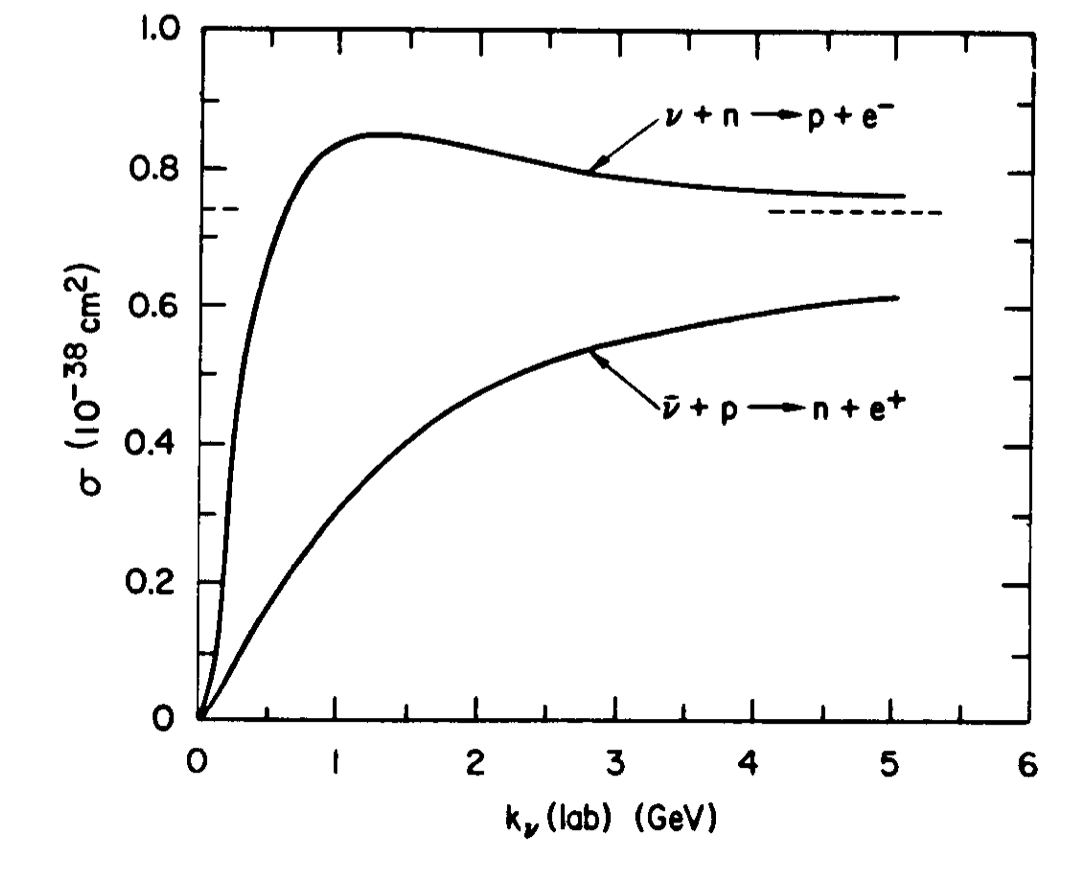
</div>

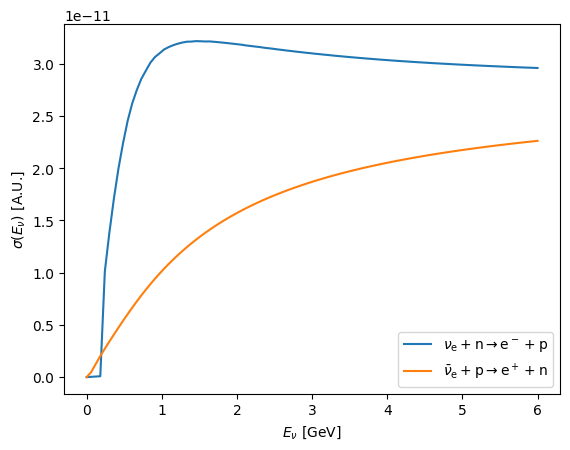

In [19]:
enus = np.linspace(m_e,6,100)
sig_numu = [LSQESigma(enu,12) for enu in enus]
sig_numubar = [LSQESigma(enu,-12) for enu in enus]

plt.plot(enus,sig_numu,label=r"$\nu_\text{e} + \text{n} \rightarrow \text{e}^- + \text{p}$")
plt.plot(enus,sig_numubar,label=r"$\bar{\nu}_\text{e} + \text{p} \rightarrow \text{e}^+ + \text{n}$")
plt.ylabel(r"$\sigma(E_\nu)$ [A.U.]")
plt.xlabel(r"$E_\nu$ [GeV]")
plt.legend()
plt.show()

### Success!

We have reproduced a plot from a 50 year old paper for two-body quasi-elastic scattering. Break out the champagne 🥂

**Points at LSQEDSigmaDQ2Physical** *Is this an event generator?*

**Slaps top of LSQESigma** *This function can calculate so many cross sections!*

Now we have implemented a model, its time to build the actual event generator.

<hr>

### Questions

* Why is there a small offset for the turn on for $\nu$ (and not $\bar{\nu}$) in our cross section? Can you reproduce the LS plot more exactly?
* The $Q^2_\text{max}$ finding is inefficient, can you calculate the $Q^2$ limits analytically? Clue: Square equation [4], take the physical limit, and use the quadratic formular in $Q^2$.
* Why does the cross section flatten off for $\nu$? Does it flatten off for $\bar{\nu}$?
* Why the bump at low energy for $\nu$ and not for $\bar{\nu}$?
* What are the implications of the radically different $\nu$ and $\bar{\nu}$ cross sections for CPV searches at few-GeV experiments?

<hr>

## Aside: Monte Carlo Sampling

statistical error on the mean of the function goes like the number of attempts?

In [20]:
from scipy.stats import uniform
from scipy.optimize import minimize_scalar

class RejectionSampler1D(object):
    def __init__(self, fcn, xrange, headroom = 1.05):
        self.fcn = fcn
        self.xrange = xrange
        
        self.ceiling = -minimize_scalar(lambda x: -fcn(x), bounds=xrange).fun * headroom
        
        self.accepted = ([],[])
        self.rejected = ([],[])

    def sample(self):
        x = uniform.rvs(self.xrange[0], self.xrange[1] - self.xrange[0])
        fx = self.fcn(x)
        y = uniform.rvs(0, self.ceiling)
        
        while y > fx:
            self.rejected[0].append(x)
            self.rejected[1].append(y)
        
            x = uniform.rvs(self.xrange[0], self.xrange[1] - self.xrange[0])
            fx = self.fcn(x)
            y = uniform.rvs(0, self.ceiling)

        self.accepted[0].append(x)
        self.accepted[1].append(y)
        
        return x, fx


NameError: name 'lssigenu' is not defined

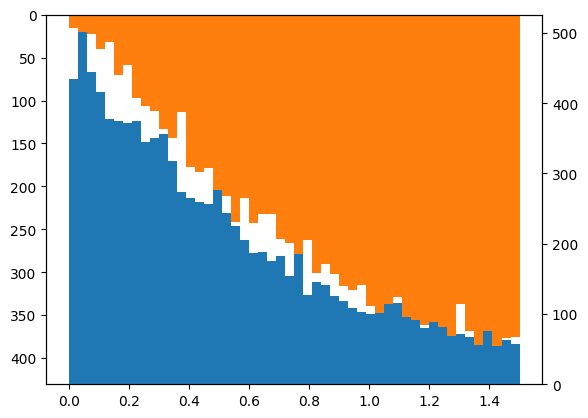

In [24]:
enu = 1.0 # in GeV
nupid = 14 # muon neutrino

rejs = RejectionSampler1D(lambda Q2: LSQEDSigmaDQ2(enu, Q2, nupid), (0,1.5*enu))

nsamples = 10000

for _ in range(nsamples):
    Q2, dsdQ2 = rejs.sample()

Q2r = (0,1.5*enu)
nbins = 50
Q2linspace = np.linspace(*Q2r,nbins+1)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

cols=plt.rcParams['axes.prop_cycle'].by_key()['color']

accy, _ = np.histogram(rejs.accepted[0],bins=Q2linspace)
rejy, _ =  np.histogram(rejs.rejected[0],bins=Q2linspace)

bincenters = 0.5*(Q2linspace[1:]+Q2linspace[:-1])
binwidth = Q2linspace[1] - Q2linspace[0]

ax1.invert_yaxis()
ax2.bar(bincenters, accy, width=binwidth, label = "accepted samples", color=cols[0])
ax1.bar(bincenters, rejy, width=binwidth, label = "rejected samples", color=cols[1])

norm = nsamples*(Q2r[1] - Q2r[0])/(nbins*lssigenu(enu,nupid)[0])
diffxs = [LSQEDSigmaDQ2(enu, Q2, nupid) * norm for Q2 in Q2linspace]

ax2.plot(Q2linspace, diffxs, c='black', label = r"d$\sigma$/d$Q^{2}(Q^{2})|_{E_{\nu}}$", linestyle="dashed")

ax1.set_xlabel(r"$Q^{2}$ [GeV$^{2}$]")

ax1.set_ylabel(r"Rejected Samples")
ax2.set_ylabel(r"Accepted Samples")

fig.legend()
fig.show()


## The Event Generator

flux rej-sampling, coupled/weighted/pre-calc totxs

In [ ]:
def diffxs_1E38cm2(E_nu_GeV, Q2_GeV2, nupid):
    return diffxs(E_nu_GeV, Q2_GeV2, nupid) * 1E38 / cm2

In [ ]:
def CalcQ2(enu, elep, mlep, costhetalep):
    plep = np.sqrt(elep*elep - mlep*mlep)
    q0 = enu - elep
    q3sq = enu*enu + plep*plep - 2*enu*plep*costhetalep

    return q3sq - q0*q0

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

elep, costhetalep = np.meshgrid(np.linspace(m_mu, 5, 100), np.linspace(-1, 1, 100))
q2 = CalcQ2(5,elep,m_mu,costhetalep)
# # elep and costhetalep are bounds, so q2 should be the value *inside* those bounds.
# # Therefore, remove the last value from the z array.
q2 = q2[:-1, :-1]
z_min, z_max = q2.min(), q2.max()

fig, ax = plt.subplots()

c = ax.pcolormesh(elep, costhetalep, q2, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([elep.min(), elep.max(), costhetalep.min(), costhetalep.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
enu = 1
elep = np.linspace(m_mu*1.0001,enu*0.9999,100)

pnuc = [ CalcKinematics(enu, el, m_mu, m_p)[0] for el in elep ]
lepct = [ CalcKinematics(enu, el, m_mu, m_p)[1] for el in elep ]
nucct = [ CalcKinematics(enu, el, m_mu, m_p)[2] for el in elep ]
Q2 = [ CalcKinematics(enu, el, m_mu, m_p)[3] for el in elep ]
plep = [ CalcKinematics(enu, el, m_mu, m_p)[4] for el in elep ]

plt.plot(elep, pnuc)
plt.show()
plt.plot(elep, lepct)
plt.show()
plt.plot(elep, nucct)
plt.show()
plt.plot(elep, Q2)
plt.show()

plt.plot(elep, plep)
plt.show()


In [ ]:
nu = vector.obj(x=0,y=0,z=0.114,mass=0)
inuc = vector.obj(x=0,y=0,z=0,mass=m_n)
fsl = vector.obj(x=0,y=0,z=0,mass=m_mu)
fnuc = vector.obj(x=0,y=0,z=0,mass=m_p)

In [ ]:
print("imass = %s" % (nu+inuc).M)
print("fminmass = %s" % (fsl+fnuc).M)

In [ ]:
#choose ELep, ctlep
enu = 5

# elep = uniform.rvs(m_mu, enu)
# plep = np.sqrt(elep*elep - m_mu*m_mu)
# ctlep = uniform.rvs(-1,2)
# print(elep,ctlep)
print(CalcNucKinematics(enu,1, m_mu, m_p,0.5))

In [ ]:
elep, costhetalep = np.meshgrid(np.linspace(m_mu, enu-0.1, 10), np.linspace(-1, 1, 10))
pnuc = CalcNucKinematics(enu,elep,m_mu,m_p,costhetalep)[0]
thetanuc = CalcNucKinematics(enu,elep,m_mu,m_p,costhetalep)[1]
# # elep and costhetalep are bounds, so thetanuc should be the value *inside* those bounds.
# # Therefore, remove the last value from the z array.
thetanuc = thetanuc[:-1, :-1]
z_min, z_max = thetanuc.min(), thetanuc.max()

fig, ax = plt.subplots()

c = ax.pcolormesh(elep, costhetalep, thetanuc, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([elep.min(), elep.max(), costhetalep.min(), costhetalep.max()])
fig.colorbar(c, ax=ax)

plt.show()

sthetanuc = np.sqrt(1 - np.power(thetanuc,2))
z_min, z_max = sthetanuc.min(), sthetanuc.max()

fig, ax = plt.subplots()

c = ax.pcolormesh(elep, costhetalep, sthetanuc, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([elep.min(), elep.max(), costhetalep.min(), costhetalep.max()])
fig.colorbar(c, ax=ax)

plt.show()

pnuc = pnuc[:-1, :-1]
z_min, z_max = pnuc.min(), pnuc.max()

fig, ax = plt.subplots()

c = ax.pcolormesh(elep, costhetalep, pnuc, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([elep.min(), elep.max(), costhetalep.min(), costhetalep.max()])
fig.colorbar(c, ax=ax)

plt.show()